In [1]:
%pip install --upgrade --quiet  langchain langchain-community langchain-ollama langchain-experimental neo4j tiktoken yfiles_jupyter_graphs python-dotenv json-repair langchain-openai langchain_core


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from langchain_core.runnables import  RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_community.graphs import Neo4jGraph
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.chat_models import ChatOllama
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from langchain_community.vectorstores import Neo4jVector
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_ollama import OllamaEmbeddings
import os
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from neo4j import  Driver

from dotenv import load_dotenv

load_dotenv()

False

In [3]:
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "your_password"
os.environ["NEO4J_URI"] = "bolt://localhost:7687"

graph = Neo4jGraph()

/tmp/ipykernel_2389/274384884.py:5: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph = Neo4jGraph()


In [3]:
loader = TextLoader(file_path="hteritgfood_extracted.txt")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=24)
documents = text_splitter.split_documents(documents=docs)

In [5]:
llm = OllamaFunctions(model="llama3.1:8b", temperature=0, format="json")

llm_transformer = LLMGraphTransformer(llm=llm)

graph_documents = llm_transformer.convert_to_graph_documents(docs)

In [9]:
graph_documents

[GraphDocument(nodes=[Node(id='Marie Curie', type='Person', properties={}), Node(id='Poland', type='Country', properties={}), Node(id='France', type='Country', properties={})], relationships=[Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='Poland', type='Country', properties={}), type='BORN_IN', properties={}), Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='France', type='Country', properties={}), type='NATURALISED_IN', properties={})], source=Document(metadata={'source': 'dummytext.txt'}, page_content='Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.')),
 GraphDocument(nodes=[Node(id='Marie Curie', type='Person', properties={})], relationships=[Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='Nobel Prize', type='Award', properties={}), type='WINNER', properties={}), Relation

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

def convert_graph_documents_to_nx(graph_documents):
    G = nx.DiGraph()
    for graph_doc in graph_documents:
        for node in graph_doc.nodes:
            G.add_node(node.id, type=node.type, **node.properties)
        for rel in graph_doc.relationships:
            G.add_edge(
                rel.source.id,
                rel.target.id,
                type=rel.type,
                **rel.properties
            )
    return G


In [26]:
def visualize_with_networkx(G):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 10))
    node_types = nx.get_node_attributes(G, 'type')
    nx.draw_networkx_nodes(
        G, pos, node_color='lightblue', node_size=200, alpha=0.9
    )
    edge_labels = nx.get_edge_attributes(G, 'type')
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=8
    )

    plt.title("Graph Visualization")
    plt.axis("off")
    plt.show()


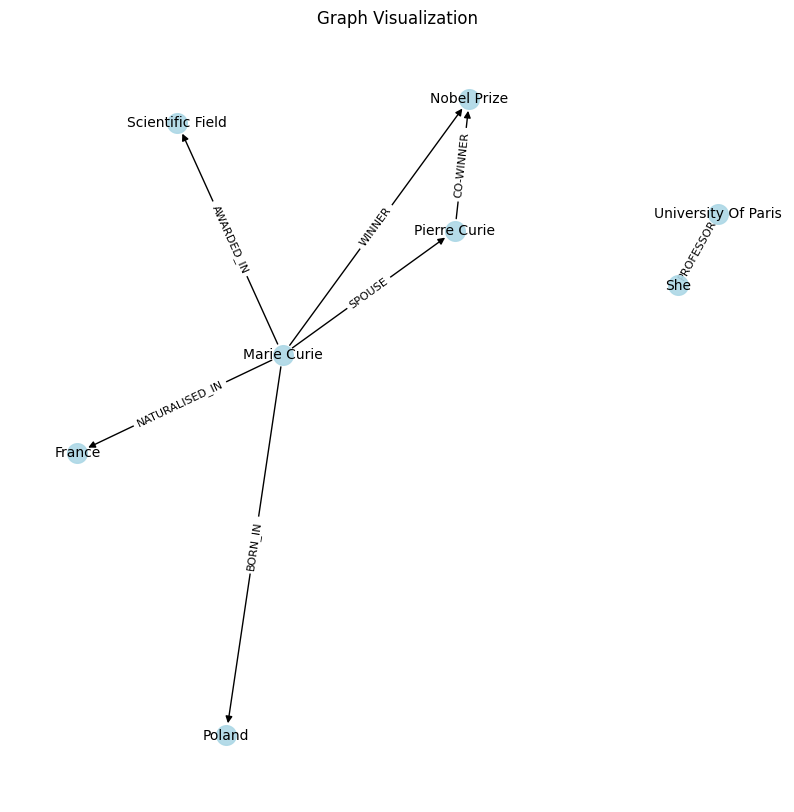

In [30]:
G = convert_graph_documents_to_nx(graph_documents)
visualize_with_networkx(G)
